In [1]:
import sounddevice as sd
import numpy as np
import librosa
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
from datasets import load_dataset, DatasetDict
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa.display
import wave
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer
import soundfile as sf

/home/ashgatsy/miniconda3/envs/vp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def record_audio(duration=5, fs=44100):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64')
    sd.wait()  # Wait until recording is finished
    print("Recording finished.")
    return recording

In [3]:
def save_audio(recording, filename, fs=44100):
    # Ensure the audio is in the correct format
    recording_int = np.int16(recording * 32767)
    wav.write(filename, fs, recording_int)

In [4]:
def visualize(path: str): 
    raw = wave.open(path) 
    signal = raw.readframes(-1) 
    signal = np.frombuffer(signal, dtype ="int16") 
    f_rate = raw.getframerate() 
    time = np.linspace( 
        0, # start 
        len(signal) / f_rate, 
        num = len(signal) 
    ) 
    plt.figure(1) 
    plt.title("Sound Wave") 
    plt.xlabel("Time") 
    plt.plot(time, signal) 
    plt.show() 

Recording...
Recording finished.
MFCCs shape: (13, 431)


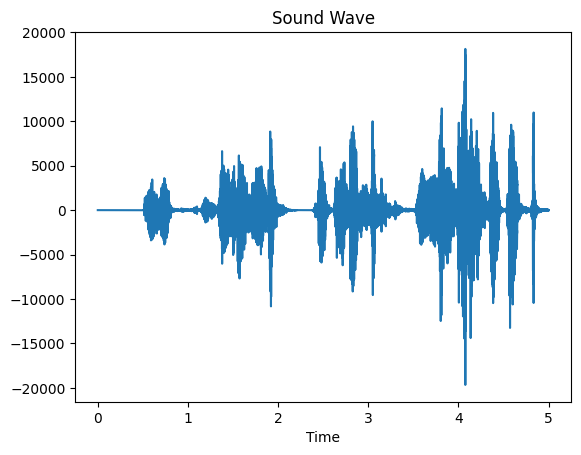

In [5]:
duration = 5  # seconds
fs = 44100  # Sampling rate

# Record audio
recording = record_audio(duration=duration, fs=fs)

# Save the recording to a file
filename = 'recorded_audio.wav'
save_audio(recording, filename, fs)

# Load the saved audio file and extract features using librosa
y, sr = librosa.load(filename, sr=fs)
hop_length = 512
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
print("MFCCs shape:", mfccs.shape)

# Plot the MFCCs
visualize('recorded_audio.wav')

In [6]:
# Define the model and processor
model_name = "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

/home/ashgatsy/miniconda3/envs/vp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def predict_emotion(file_path):
    # Load the audio file
    speech, sample_rate = sf.read(file_path)
    
    # Resample to 16kHz if necessary
    if sample_rate != 16000:
        speech = librosa.resample(speech, orig_sr=sample_rate, target_sr=16000)
        sample_rate = 16000
    
    # Process the audio
    inputs = processor(speech, sampling_rate=sample_rate, return_tensors="pt", padding=True)
    
    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits
    
    # Extract predicted label
    predicted_id = torch.argmax(logits, dim=-1).item()
    labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    emotion = labels[predicted_id]
    
    return emotion

In [8]:
# Test the function with a sample audio file
file_path = 'recorded_audio.wav'
predicted_emotion = predict_emotion(file_path)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: neutral


In [19]:
# # Preprocess the audio data
# def preprocess_function(batch):
#     audio = batch["audio"]
#     batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_values[0]
#     batch["labels"] = batch["label"]
#     return batch

In [20]:
# # Function to compute metrics
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc}

In [21]:
# # Function to predict emotion from an audio file
# def predict_emotion(filename):
#     y, sr = librosa.load(filename, sr=fs)
#     input_values = processor(y, sampling_rate=sr, return_tensors="pt").input_values
#     with torch.no_grad():
#         logits = model(input_values).logits
#     predicted_id = torch.argmax(logits, dim=-1).item()
#     return predicted_id